### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.nn import LogitLens, TunedLens

from pii import utils
from pii.prompt_data import LensData, PromptData
from pii.subnet_flow.masked_model import PerTokenMaskedTransformer

torch.set_grad_enabled(False)

### Load model / lenses

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)
logit_lens = LogitLens.from_model(hf_model).to("cuda")
tuned_lens = TunedLens.from_model_and_pretrained(hf_model).to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

'The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions'

### Develop prompts

In [156]:
def get_corr_prompt(question: str, correct: bool = True):
    return f"""\
[INST] <<SYS>>
You are an assistant who only responds with a single word. \
You only give {'correct' if correct else 'incorrect'} answers.
<</SYS>>
Complete the sentence. {question} [/INST] \
"""


def get_dontsay_prompt(question: str, forbidden_word: str):
    return f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You are not allowed to say the forbidden word {forbidden_word}.
<</SYS>>
{question} [/INST] \
"""

# question = "Miles Davis plays the"
# forbidden_words = ["apple", "Trumpet"]
question = "Lionel Messi plays the sport of"
forbidden_words = ["apple", "football"]
# question = "Carlos Alcaraz plays the sport of"
# forbidden_words = ["apple", "Tennis"]
# question = "The capital of Germany is"
# forbidden_words = ["apple", "Berlin"]

tl_model.remove_all_hook_fns(including_permanent=True)

In [157]:
for i, corr in enumerate([True, False]):
    prompt = get_corr_prompt(question, correct=corr)
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=tl_model,
        top_k=5,
    )
    if i == 0:
        print()

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>
Complete the sentence. Lionel Messi plays the sport of [/INST] 
Rank 0. Logit: 25.53 Prob: 88.58% Tokens: ( 8914) |Football|</s>|
Rank 1. Logit: 23.42 Prob: 10.74% Tokens: (18993) |Soccer|</s>|
Rank 2. Logit: 20.15 Prob:  0.41% Tokens: ( 5733) |football|</s>|
Rank 3. Logit: 19.08 Prob:  0.14% Tokens: ( 7527) |Foot|bal|</s>|
Rank 4. Logit: 18.12 Prob:  0.05% Tokens: (13440) |Foot|ball|</s>|

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give incorrect answers.
<</SYS>>
Complete the sentence. Lionel Messi plays the sport of [/INST] 
Rank 0. Logit: 13.98 Prob: 14.43% Tokens: (29010) |Tennis|</s>|
Rank 1. Logit: 13.65 Prob: 10.42% Tokens: (  402) |G|olf|</s>|
Rank 2. Logit: 13.57 Prob:  9.60% Tokens: (  349) |P|ing|-|P|ong|.|
Rank 3. Logit: 13.40 Prob:  8.06% Tokens: (21850) |Basketball|</s>|
Rank 4. Logit: 13.18 Prob:  6.51% Tokens: (  323)

In [158]:
for i, forbidden_word in enumerate(forbidden_words):
    prompt = get_dontsay_prompt(question, forbidden_word)
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=tl_model,
        top_k=5,
    )
    if i == 0:
        print()

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word apple.
<</SYS>>
Lionel Messi plays the sport of [/INST] 
Rank 0. Logit: 23.56 Prob: 76.29% Tokens: ( 8914) |Football|</s>|
Rank 1. Logit: 22.33 Prob: 22.31% Tokens: (18993) |Soccer|</s>|
Rank 2. Logit: 18.57 Prob:  0.52% Tokens: ( 5733) |football|</s>|
Rank 3. Logit: 17.80 Prob:  0.24% Tokens: (20582) |Fut|bol|</s>|
Rank 4. Logit: 17.73 Prob:  0.22% Tokens: ( 7527) |Foot|bal|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word football.
<</SYS>>
Lionel Messi plays the sport of [/INST] 
Rank 0. Logit: 20.07 Prob: 97.57% Tokens: (18993) |Soccer|</s>|
Rank 1. Logit: 14.70 Prob:  0.45% Tokens: (18585) |Sure|!|Here|is|my|response|
Rank 2. Logit: 14.54 Prob:  0.39% Tokens: (  376) |"|S|occer|"|</s>|
Rank 3. Logit: 14.43 Prob:  0.35% Tokens: (21850) |Basketball|</s>|
Rank 4. Logit: 14

### Cache activations and compute lens data

In [159]:
prompt_dict = dict(
    corr_base=PromptData.get_data(get_corr_prompt(question), tl_model),
    corr_competing=PromptData.get_data(get_corr_prompt(question, correct=False), tl_model),
    dontsay_base=PromptData.get_data(get_dontsay_prompt(question, forbidden_words[0]), tl_model),
    dontsay_competing=PromptData.get_data(get_dontsay_prompt(question, forbidden_words[1]), tl_model),
)

for prompt_type in ["corr", "dontsay"]:
    base_data = prompt_dict[f"{prompt_type}_base"]
    competing_data = prompt_dict[f"{prompt_type}_competing"]

    print(f"Logits for {prompt_type}_base")
    print(base_data.ml_str, base_data.ml_token, base_data.final_logits[base_data.ml_token].item())
    print(competing_data.ml_str, competing_data.ml_token, base_data.final_logits[competing_data.ml_token].item())
    print(f"Logits for {prompt_type}_competing")
    print(base_data.ml_str, base_data.ml_token, competing_data.final_logits[base_data.ml_token].item())
    print(competing_data.ml_str, competing_data.ml_token, competing_data.final_logits[competing_data.ml_token].item())

lens_dict = {
    k: LensData.get_data(
        prompt_data=v,
        tl_model=tl_model,
        logit_lens=logit_lens,
        tuned_lens=tuned_lens,
    )
    for k, v in prompt_dict.items()
}

Logits for corr_base
Football 8914 25.534530639648438
Tennis 29010 10.139209747314453
Logits for corr_competing
Football 8914 12.396673202514648
Tennis 29010 13.980133056640625
Logits for dontsay_base
Football 8914 23.562816619873047
Soccer 18993 22.33326530456543
Logits for dontsay_competing
Football 8914 11.69559383392334
Soccer 18993 20.069801330566406
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now


### Plot by head

In [161]:
lens_type = "logit"
for prompt_type in ["dontsay"]:
    ld_base = lens_dict[f"{prompt_type}_base"]
    ld_comp = lens_dict[f"{prompt_type}_competing"]

    for ld, title in [
        (ld_base, f"{prompt_type} (base)"),
        (ld_comp, f"{prompt_type} (competing)"),
    ]:
        logits, labels = ld.get_logits("attn_head", lens_type=lens_type)
        utils.plot_head_data(
            lines=[
                (
                    f"{lens_type}: |{ld_base.pd.ml_str}|",
                    logits[:, ld_base.pd.ml_token],
                    labels,
                ),
                (
                    f"{lens_type}: |{ld_comp.pd.ml_str}|",
                    logits[:, ld_comp.pd.ml_token],
                    labels,
                ),
            ],
            annotation_text=ld_base.pd.prompt.split("\n")[-1],
            title=title,
            yaxis_title="Logit",
        ).show()

    # for ld, title in [
    #     (ld_base, f"{prompt_type} (base)"),
    #     (ld_comp, f"{prompt_type} (competing)"),
    # ]:
    #     logits, labels = ld.get_logits("mlp_out", lens_type=lens_type)
    #     utils.plot_head_data(
    #         lines=[
    #             (
    #                 f"{lens_type}: |{ld_base.pd.ml_str}|",
    #                 logits[:, ld_base.pd.ml_token],
    #                 labels,
    #             ),
    #             (
    #                 f"{lens_type}: |{ld_comp.pd.ml_str}|",
    #                 logits[:, ld_comp.pd.ml_token],
    #                 labels,
    #             ),
    #         ],
    #         annotation_text=ld_base.pd.prompt.split("\n")[-1],
    #         title=title,
    #         yaxis_title="Logit",
    #     ).show()

### Attention plots

In [227]:
ld = lens_dict[f"dontsay_competing"]
cache = ld.pd.cache

layer = 26
head = 9
pattern = cache["pattern", layer][head]

print(f"Layer {layer} Head {head} Attention Pattern:")
display(
    cv_tokens.colored_tokens(["<< bos >>"] + ld.pd.token_strs[1:], pattern[-1])
)
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + ld.pd.token_strs[1:], np.arange(len(ld.pd.token_strs))
    )
)

Layer 26 Head 9 Attention Pattern:


Least likely tokens for L26H9
football (-21.349) football (-19.363) Football (-16.656) Foot (-11.905) callback (-11.246) 
footballer (-10.852) callback (-10.539) follow (-10.109) follow (-9.934) футбо (-9.879) 
officials (-9.753) follows (-9.741) followed (-9.559) fool (-9.394) footer (-9.379) 
Official (-9.042) official (-9.008) listade (-8.896) piłkar (-8.895) foo (-8.845) 
rout (-8.839) officiel (-8.752) oficial (-8.697) borough (-8.695) ië (-8.681) 
Sold (-8.469) foo (-8.375) food (-8.293) email (-8.288) ież (-8.148) 
protocol (-8.141) footer (-8.112) foot (-7.983) following (-7.904) agli (-7.823) 
faithful (-7.820) iei (-7.750) Fußball (-7.736) aircraft (-7.735) feet (-7.719) 
odel (-7.708) functions (-7.685) widget (-7.669) imientos (-7.667) 球 (-7.666) 
uniform (-7.620) бли (-7.599) fø (-7.550) frequencies (-7.540) download (-7.527) 


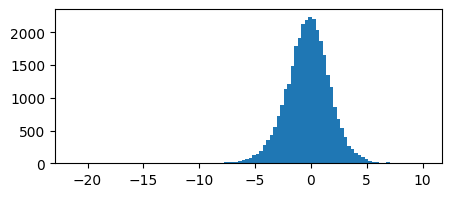

In [163]:
head_logits = ld.get_logits(
    "attn_head",
    lens_type="logit",
    flatten=False,
    zero_mean=False,
)[0][layer, head]

print(f"Least likely tokens for L{layer}H{head}")
top_tokens = torch.topk(-head_logits, 50).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({head_logits[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

plt.figure(figsize=(5, 2))
plt.hist(
    head_logits
    .cpu()
    .numpy(),
    bins=100,
)
plt.show()

### Analyze OV circuit

In [164]:
ftok = tl_model.to_single_token("football")
fpos = 35
assert ld.pd.tokens[fpos].item() == ftok

E_f = tl_model.W_E[ftok]
U_f = tl_model.W_U[:, ftok]
vs = cache["v", layer][:, head]
attn_pattern = cache["pattern", layer][head, -1]
result = cache["result", layer][-1, head]

ln_final = tl_model.ln_final
ln1 = tl_model.blocks[layer].ln1
W_V = tl_model.W_V[layer, head]
b_V = tl_model.b_V[layer, head]
W_O = tl_model.W_O[layer, head]


def print_stat(label: str, val: torch.Tensor):
    print(f"{label:<64}: {val.item():.6f}")


def f_logit(x):
    return ln_final(x) @ U_f


print(f"L{layer}H{head} stats:")
print_stat("f_logit(result)", f_logit(result))
print_stat(
    "f_logit(pattern @ vs @ W_O)",
    f_logit(attn_pattern @ vs @ W_O),
)
print_stat(
    "f_logit(pattern[fpos] * vs[fpos] @ W_O)",
    f_logit(attn_pattern[fpos] * vs[fpos] @ W_O),
)
print()
print_stat(
    "f_logit(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)",
    f_logit(attn_pattern[fpos] * ln1(E_f) @ W_V @ W_O),
)
print_stat(
    "f_logit(pattern[fpos] * E[fpos] @ W_V @ W_O)",
    f_logit(attn_pattern[fpos] * E_f @ W_V @ W_O),
)
print()
print_stat(
    "pattern[fpos] * E[fpos] @ W_V @ W_O @ U[ftok]",
    attn_pattern[fpos] * E_f @ W_V @ W_O @ U_f,
)

L26H9 stats:
f_logit(result)                                                 : -19.363449
f_logit(pattern @ vs @ W_O)                                     : -19.363449
f_logit(pattern[fpos] * vs[fpos] @ W_O)                         : -19.426025

f_logit(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)               : -12.430183
f_logit(pattern[fpos] * E[fpos] @ W_V @ W_O)                    : -12.243249

pattern[fpos] * E[fpos] @ W_V @ W_O @ U[ftok]                   : -0.032979


tensor(-12.5197, device='cuda:0')
Tokens L26H9 most downweights from raw embedding
service (-45.756) development (-45.380) follow (-43.818) read (-42.987) features (-42.426) 
family (-42.389) release (-41.461) services (-41.453) develop (-40.856) individual (-40.556) 
developed (-39.357) organization (-38.371) study (-38.284) feature (-38.129) reading (-37.992) 
Development (-36.977) leader (-36.628) force (-36.596) writing (-36.578) change (-36.422) 
available (-36.365) professional (-36.166) studies (-35.603) developing (-35.208) examples (-34.962) 
image (-34.801) Service (-34.740) following (-34.442) company (-34.427) students (-33.909) 
leaders (-33.895) address (-33.813) write (-33.704) provided (-33.644) cause (-33.610) 
issues (-33.326) government (-33.114) service (-33.101) changes (-33.037) forces (-33.034) 
Develop (-32.914) follows (-32.799) see (-32.625) released (-32.555) security (-32.487) 
use (-32.449) country (-32.416) companies (-32.411) issue (-32.289) approach (-32

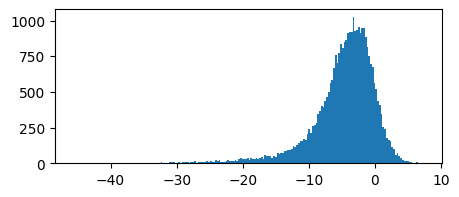

In [165]:
m1 = W_V @ W_O
rmsdiv = lambda x: x / x.pow(2).mean(dim=-1, keepdim=True).sqrt()
m2 = torch.diag(tl_model.ln_final.w) @ tl_model.W_U

responses = (rmsdiv(tl_model.W_E @ m1) @ m2).diag()
print(responses[ftok])
print(f"Tokens L{layer}H{head} most downweights from raw embedding")
top_tokens = torch.topk(-responses, 50).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({responses[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

plt.figure(figsize=(5, 2))
plt.hist(responses.cpu().numpy(), bins=200);

### Key enrichment of forbidden word token

resid.shape torch.Size([27, 58, 4096])
attn.shape torch.Size([27, 58])
tensor(0.6348, device='cuda:0')


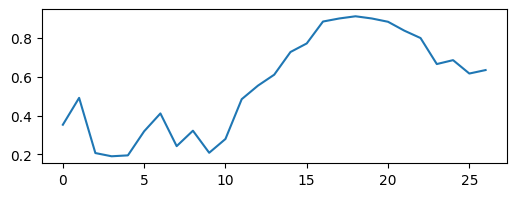

In [166]:
rot_q_final = cache["rot_q", layer][-1, head]
attn_scale = tl_model.blocks[layer].attn.attn_scale

resid = torch.stack([cache["resid_pre", l] for l in range(layer + 1)])
print("resid.shape", resid.shape)
assert resid.shape == (layer + 1, ld.pd.n_tokens, tl_model.cfg.d_model)
assert tl_model.b_K.abs().max() == 0

resid_norm = tl_model.blocks[layer].ln1(resid)
ks = resid_norm @ tl_model.W_K[layer, head]
ks = einops.rearrange(ks, "layer pos d -> 1 pos layer d")
rot_ks = tl_model.blocks[layer].attn.apply_rotary(ks)
rot_ks = einops.rearrange(rot_ks, "1 pos layer d -> layer pos d")

logits = (rot_ks @ rot_q_final) / attn_scale
attn = logits.softmax(dim=-1)
print("attn.shape", logits.shape)

print(attn[:, fpos][-1])
plt.figure(figsize=(6,2))
plt.plot(attn[:, fpos].cpu().numpy())
plt.show()

# cv_attention.attention_pattern(
#     ld.pd.token_strs,
#     attn, 
#     mask_upper_tri=False,
# )

### Query enrichment of final token

rot_ks.shape torch.Size([58, 128])
final_resid.shape torch.Size([27, 58, 4096])
qs.shape torch.Size([1, 58, 27, 128])
rot_qs.shape torch.Size([27, 58, 128])
final_rot_qs.shape torch.Size([27, 128])
attn.shape torch.Size([27, 58])
tensor(0.6348, device='cuda:0')


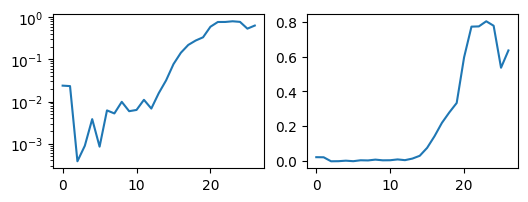

In [167]:
attn_scale = tl_model.blocks[layer].attn.attn_scale
rot_ks = cache["rot_k", layer][:, head]
print("rot_ks.shape", rot_ks.shape)

final_resid = torch.stack([cache["resid_pre", l] for l in range(layer + 1)])
print("final_resid.shape", final_resid.shape)

final_resid_norm = tl_model.blocks[layer].ln1(final_resid)
qs = final_resid_norm @ tl_model.W_Q[layer, head]
qs = einops.rearrange(qs, "layer pos d -> 1 pos layer d")
print("qs.shape", qs.shape)

rot_qs = tl_model.blocks[layer].attn.apply_rotary(qs)
rot_qs = einops.rearrange(rot_qs, "1 pos layer d -> layer pos d")
print("rot_qs.shape", rot_qs.shape)

final_rot_qs = rot_qs[:, -1]
print("final_rot_qs.shape", final_rot_qs.shape)

logits = (final_rot_qs @ rot_ks.T) / attn_scale
attn = logits.softmax(dim=-1)
print("attn.shape", attn.shape)

print(attn[layer, fpos])

plt.figure(figsize=(6,2))
plt.subplot(1, 2, 1)
plt.plot(attn[:, fpos].cpu().numpy())
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(attn[:, fpos].cpu().numpy())
plt.show()

# cv_attention.attention_pattern(
#     ld.pd.token_strs,
#     attn, 
#     mask_upper_tri=False,
# )

### Masking out effect of question tokens on head we are studying

In [382]:
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + ld.pd.token_strs[1:], np.arange(len(ld.pd.token_strs))
    )
)

attn_del_q = torch.zeros_like(ld.pd.tokens).bool()
attn_del_q[53:] = 1

# These tokens will not be attended to
attn_del_k = torch.zeros_like(ld.pd.tokens).bool()
attn_del_k[9:40] = 1
attn_del_k[41:43] = 1
attn_del_k[44:53] = 1

display(
    cv_tokens.colored_tokens(
        ld.pd.token_strs,
        attn_del_q.float(),
    )
)
display(
    cv_tokens.colored_tokens(
        ld.pd.token_strs,
        attn_del_k.float(),
    )
)

attn_del_pattern = (attn_del_q[:, None] * attn_del_k[None, :]).float()
cv_attention.attention_pattern(
    tokens=ld.pd.token_strs,
    attention=attn_del_pattern,
)

In [380]:
raw_logits = []
probs = []
for mask_limit in tqdm(range(layer + 1)):
    mtl_model = PerTokenMaskedTransformer(
        tl_model,
        base_prompt=ld.pd.prompt,
    )

    for i in range(mask_limit):
        mask = mtl_model.masks[f"{i}_attn_pattern"]
        mask[:] *= 1.0 - attn_del_pattern

    _, mcache = mtl_model.tl_model.run_with_cache(
        ld.pd.prompt,
        remove_batch_dim=True,
        names_filter=[
            tl_utils.get_act_name("z", l) for l in range(tl_model.cfg.n_layers)
        ]
        + [
            tl_utils.get_act_name("attn", l)
            for l in range(tl_model.cfg.n_layers)
        ],
    )
    mcache.compute_head_results()

    logits = logit_lens.forward(mcache["result", layer][-1, head], idx=layer)
    raw_logit = logits[ftok]
    raw_logits.append(raw_logit.item())

    prob = logits.softmax(dim=-1)[ftok]
    probs.append(prob.item())

  0%|          | 0/27 [00:00<?, ?it/s]

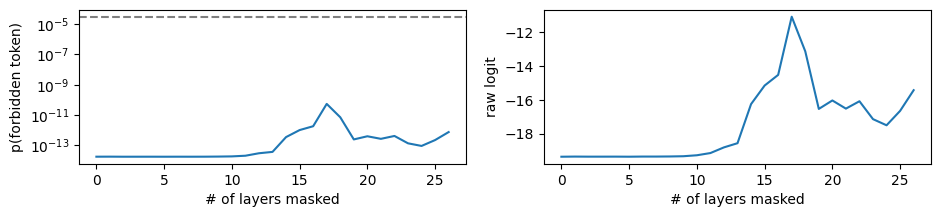

-15.433870315551758
Layer 26 Head 9 Attention Pattern:


In [381]:
plt.figure(figsize=(11, 2))

plt.subplot(1, 2, 1)
plt.plot(probs)
plt.axhline(
    1 / hf_model.config.vocab_size,
    color="black",
    linestyle="--",
    alpha=0.5,
    zorder=-1,
)
plt.yscale("log")
plt.ylabel("p(forbidden token)")
plt.xlabel("# of layers masked")

plt.subplot(1, 2, 2)
plt.plot(raw_logits)
plt.ylabel("raw logit")
plt.xlabel("# of layers masked")
plt.show()

pattern = mcache["pattern", layer][head]
print(raw_logits[-1])
print(f"Layer {layer} Head {head} Attention Pattern:")
display(
    cv_tokens.colored_tokens(["<< bos >>"] + ld.pd.token_strs[1:], pattern[-1])
)